# Collaborative Filtering Methods

In [1]:
# data analysis and wrangling
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

# functions to test
from gradientDescent import gradientDescent
from alternatingLeastSquares import ALS
from lineSearchAlgorithm import lineSearch
from cost_functions import get_Ju_and_DJu, get_Ja_and_DJa
from aux_functions import initializeQ, initializeP
from accuracyMetrics import RMSE

## Sample Data
We create a simple $5\times4$ interactions matrix to test our algorithms.

In [2]:
R = np.array(
    [
        [5, 1, np.NAN, 4],
        [np.NAN, 9, np.NAN, 2],
        [9, 2, 1, np.NAN],
        [6, np.NAN, 7, 4],
        [np.NAN, 4, 7, 5],
    ]
)

R0 = R

# Calculate the mean and standard deviation of each column (axis 0)
mean = np.nanmean(R)
std_dev = np.nanstd(R)

# Standardize the matrix
R = (R - mean) / std_dev

m, n = R.shape

We define the range $f$ for the matrices $Q$ and $P$ that will approximate $R$.

In [62]:
f = 5

We initialize $Q$ and $P$ with values from a standard normal random variable keeping a constant seed for consistent results.

In [63]:
# Seed
np.random.seed(43)

# Q and P initilization
Q = initializeQ(R.shape[0], f)
P = initializeP(R.shape[1], f)

## Line Search Test

In [64]:
Ju, DJu = get_Ju_and_DJu(R, P, f)
Q = Q.flatten()
p_k = -DJu(Q)
alpha = lineSearch(Ju, DJu, Q, p_k)
alpha

0.0625

## Optimizing $Ju$ using Gradient Descent with Line Search

In [65]:
tol = 1e-5
max_iter = 1e4

Ju, DJu = get_Ju_and_DJu(R, P, f)

Q = Q.flatten()
gradientDescentResults = gradientDescent(Ju, Q, DJu, tol, max_iter)
newQs = gradientDescentResults["x_values"]
Ju_values = gradientDescentResults["func_values"]

Calculating errors and $RMSE$

$$RMSE = \sqrt{\frac{\sum_{(u,j)}{e_{u,j}^2}}{\lvert E \rvert}}$$

In [66]:
RMSEs = []
for Q_k in newQs:
    Q_k = Q_k.reshape(R.shape[0],-1)
    errors = (Q_k @ P.T - R).flatten()

    # Check for NaN values using np.isnan()
    is_nan = np.isnan(errors)

    # Use boolean indexing to filter out NaN values
    errors = errors[~is_nan]
    RMSEs.append(RMSE(errors))

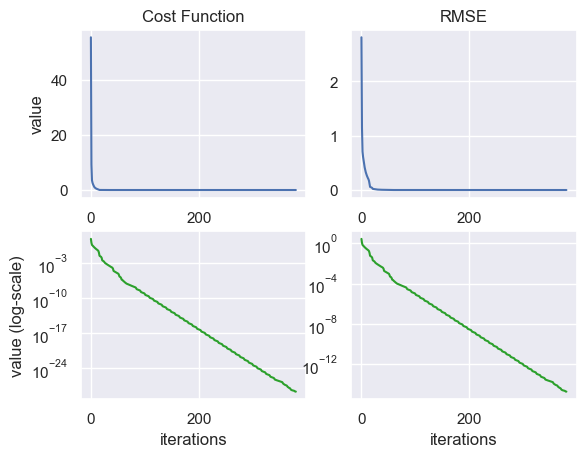

In [67]:
fig, axs = plt.subplots(2, 2)

axs[0, 0].plot(Ju_values)
axs[0, 0].set_title('Cost Function')
axs[0, 1].plot(RMSEs)
axs[0, 1].set_title('RMSE')
axs[1, 0].semilogy(Ju_values, 'tab:green')
axs[1, 1].semilogy(RMSEs, 'tab:green')

axs[0,0].set(xlabel='iterations', ylabel='value')
axs[1,0].set(xlabel='iterations', ylabel='value (log-scale)')
axs[1,1].set(xlabel='iterations')

plt.show()

In [68]:
newR = newQs[-1].reshape(R.shape[0], -1) @ P.T
newR = newR * std_dev + mean

In [69]:
pd.DataFrame(np.around(newR, 2))

,0,1,2,3
0,5.00,1.00,8.59,4.0
1,3.24,9.00,4.55,2.0
2,9.00,2.00,1.00,12.2
3,6.00,2.45,7.00,4.0
4,4.63,4.00,7.00,5.0


In [70]:
pd.DataFrame(R0)

,0,1,2,3
0,5.0,1.0,NaN,4.0
1,NaN,9.0,NaN,2.0
2,9.0,2.0,1.0,NaN
3,6.0,NaN,7.0,4.0
4,NaN,4.0,7.0,5.0


## Testing ALS method for collaborative filtering

In [3]:
np.random.seed(43)
f = 4
alternations = 4
tol = 1e-1
max_iter = 1e1

als_result = ALS(R, f, alternations, tol, max_iter)

In [4]:
newQ = als_result["Q"]
newP = als_result["P"]
J_values = als_result["J_values"]
RMSE_values = als_result["RMSEs"]

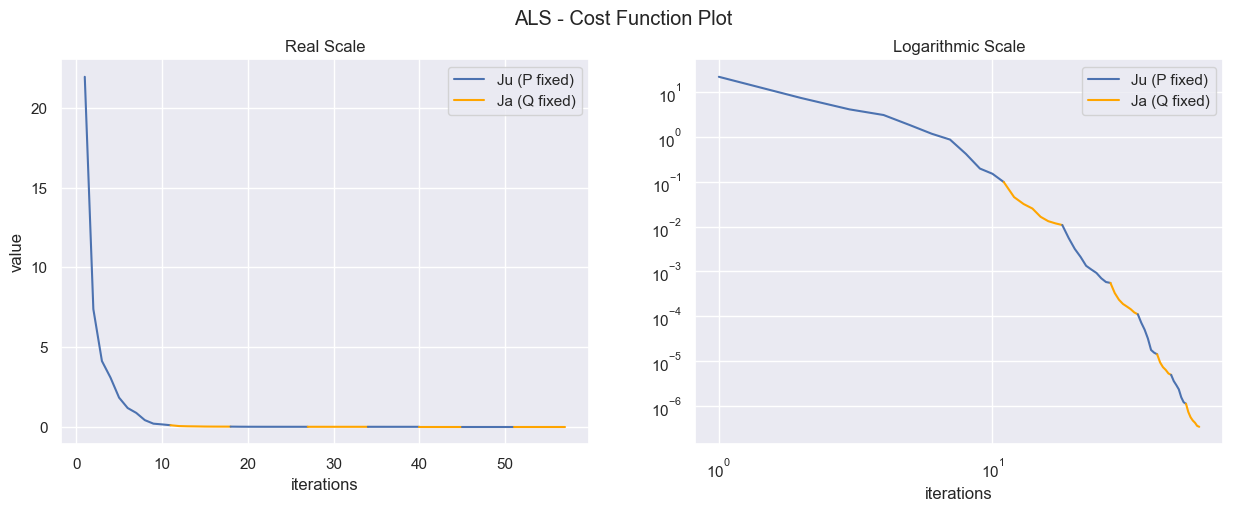

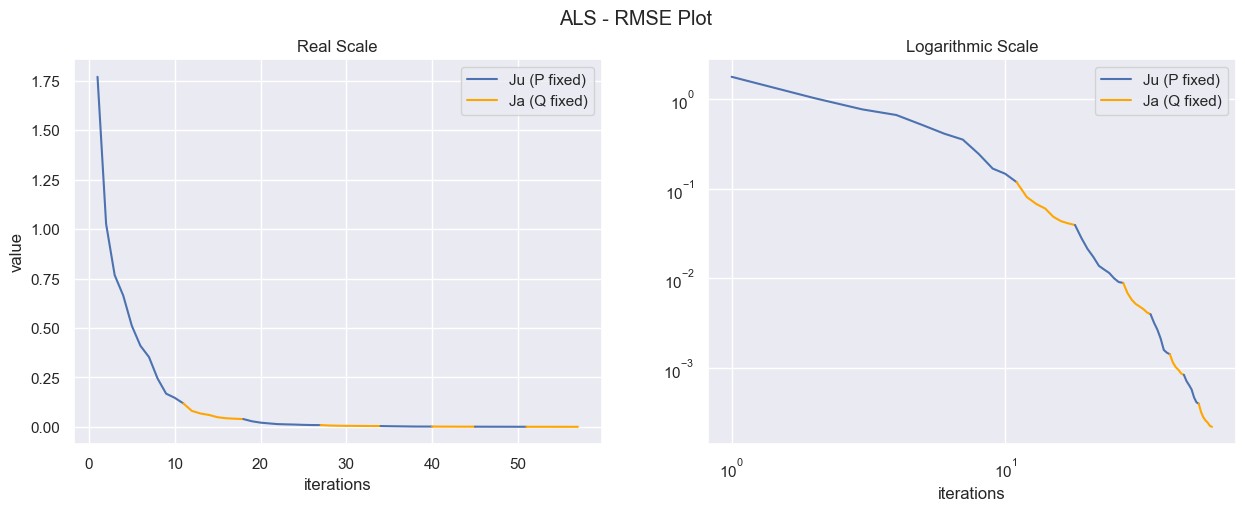

In [5]:

from plottingFunctions import plotALSResults
plotALSResults(J_values, "ALS - Cost Function Plot")
plotALSResults(RMSE_values, "ALS - RMSE Plot")

In [89]:
newR = (newQ @ newP.T) * std_dev + mean

In [90]:
pd.DataFrame(np.around(newR, 1))

,0,1,2,3
0,5.0,1.0,0.9,4.0
1,11.4,9.0,7.2,2.0
2,9.0,2.0,1.0,2.7
3,6.0,7.7,7.0,4.0
4,2.1,4.0,7.0,5.0


In [91]:
pd.DataFrame(R0)

,0,1,2,3
0,5.0,1.0,NaN,4.0
1,NaN,9.0,NaN,2.0
2,9.0,2.0,1.0,NaN
3,6.0,NaN,7.0,4.0
4,NaN,4.0,7.0,5.0
